## **MIMIC-III Exploratory Analysis**

### **Libraries**

In [25]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os, gc, math, json
import seaborn as sns
import pandas as pd
import numpy as np

## **Settings**

In [26]:
pd.set_option('display.max_columns', 120)
sns.set_style("whitegrid")

In [27]:
def downcast_df(df):
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

In [28]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [29]:
path_file = "/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4"

## **Data Listing**

In [30]:
for root, dirs, files in os.walk(path_file):
    if files:
        print(root, len(files))

/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4 28


In [31]:
patients = pd.read_csv(f"{path_file}/PATIENTS.csv")
patients.columns.tolist()

['row_id',
 'subject_id',
 'gender',
 'dob',
 'dod',
 'dod_hosp',
 'dod_ssn',
 'expire_flag']

In [32]:
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1


In [33]:
patients.shape

(100, 8)

In [34]:
patients.dtypes

row_id          int64
subject_id      int64
gender         object
dob            object
dod            object
dod_hosp       object
dod_ssn        object
expire_flag     int64
dtype: object

In [35]:
patients.isna().sum().sort_values(ascending=False)

dod_hosp       30
dod_ssn        23
row_id          0
subject_id      0
gender          0
dob             0
dod             0
expire_flag     0
dtype: int64

In [36]:
admissions = pd.read_csv(f"{path_file}/ADMISSIONS.csv")
print('admissions', admissions.shape)

admissions (129, 19)


In [37]:
labevents = pd.read_csv(f"{path_file}/LABEVENTS.csv", low_memory=False)
print('labevents', labevents.shape)

labevents (76074, 9)


### **Build a small cohort index**

In [38]:
admissions_full = pd.read_csv(f"{path_file}/ADMISSIONS.csv")
admissions_full = downcast_df(admissions_full)

In [39]:
admissions_full.columns.to_list()

['row_id',
 'subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'religion',
 'marital_status',
 'ethnicity',
 'edregtime',
 'edouttime',
 'diagnosis',
 'hospital_expire_flag',
 'has_chartevents_data']

In [40]:
admissions_full = admissions_full.dropna()
admissions_sample = admissions_full.sample(n=len(admissions_full), random_state=RANDOM_SEED).reset_index(drop=True)
cohort_hadm = set(admissions_sample['hadm_id'].unique())
len(cohort_hadm)

11

### **Load only relevant EHR tables filtered to cohort**

In [41]:
def filter_table_by_hadm(path, hadm_set, usecols=None, parse_dates=None, chunksize=200000):
    rows = []
    for chunk in pd.read_csv(path, usecols=usecols, parse_dates=parse_dates, chunksize=chunksize):
        chunk = chunk[chunk['hadm_id'].isin(hadm_set)]
        if not chunk.empty:
            rows.append(chunk)
    if rows:
        df = pd.concat(rows, ignore_index=True)
        return downcast_df(df)
    else:
        return pd.DataFrame()

In [42]:
lab_cols = ['subject_id','hadm_id','charttime','valuenum','valueuom']
labs = filter_table_by_hadm(f"{path_file}/LABEVENTS.csv", cohort_hadm, usecols=lab_cols, parse_dates=['charttime'])
print('labs rows', len(labs))

labs rows 7189


In [43]:
chart_cols = ['subject_id','hadm_id','charttime','valuenum','valueuom']
charts = filter_table_by_hadm(f"{path_file}/CHARTEVENTS.csv", cohort_hadm, usecols=chart_cols, parse_dates=['charttime'])
print('charts rows', len(charts))

/tmp/ipykernel_37/2179913147.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, usecols=usecols, parse_dates=parse_dates, chunksize=chunksize):


charts rows 127666


## **Basic demographics & LOS (Length of stay)**

In [44]:
admissions_full.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
28,12326,10076,198503,2107-03-21 21:16:00,2107-03-30 12:00:00,2107-03-30 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,MAND,NOT SPECIFIED,MARRIED,ASIAN,2107-03-21 17:24:00,2107-03-22 01:12:00,LUNG CANCER;SHORTNESS OF BREATH,1,1
52,12378,10124,170883,2192-04-16 20:57:00,2192-05-15 19:28:00,2192-05-15 19:28:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,RUSS,JEWISH,WIDOWED,WHITE,2192-04-16 11:51:00,2192-04-16 21:38:00,CONGESTIVE HEART FAILURE,1,1
72,39980,40687,129273,2155-03-08 02:35:00,2155-03-11 15:00:00,2155-03-12 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2155-03-07 18:24:00,2155-03-08 03:45:00,ABDOMINAL PAIN,1,1
92,40422,42033,154156,2131-07-26 17:13:00,2131-07-28 16:02:00,2131-07-28 16:02:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,ROMANIAN EAST. ORTH,MARRIED,WHITE,2131-07-26 15:01:00,2131-07-26 18:24:00,SHORTNESS OF BREATH,1,1
96,40463,42135,117105,2127-10-06 21:00:00,2127-10-28 12:50:00,2127-10-28 12:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,MUSLIM,MARRIED,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,2127-10-06 19:19:00,2127-10-06 22:26:00,HEPATIC ENCEP,1,1


In [45]:
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1


In [46]:
adm = patients.merge(admissions_full, on='subject_id', how='inner')
adm.head()

,row_id_x,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_y,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,9533,10076,M,2038-05-10 00:00:00,2107-03-30 00:00:00,2107-03-30 00:00:00,2107-03-30 00:00:00,1,12326,198503,2107-03-21 21:16:00,2107-03-30 12:00:00,2107-03-30 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,MAND,NOT SPECIFIED,MARRIED,ASIAN,2107-03-21 17:24:00,2107-03-22 01:12:00,LUNG CANCER;SHORTNESS OF BREATH,1,1
1,9579,10124,F,2108-12-20 00:00:00,2192-05-15 00:00:00,2192-05-15 00:00:00,2192-05-15 00:00:00,1,12378,170883,2192-04-16 20:57:00,2192-05-15 19:28:00,2192-05-15 19:28:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,RUSS,JEWISH,WIDOWED,WHITE,2192-04-16 11:51:00,2192-04-16 21:38:00,CONGESTIVE HEART FAILURE,1,1
2,30968,40687,F,2073-06-05 00:00:00,2155-03-12 00:00:00,2155-03-12 00:00:00,2155-03-12 00:00:00,1,39980,129273,2155-03-08 02:35:00,2155-03-11 15:00:00,2155-03-12 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2155-03-07 18:24:00,2155-03-08 03:45:00,ABDOMINAL PAIN,1,1
3,31323,42033,F,2045-10-07 00:00:00,2131-07-28 00:00:00,2131-07-28 00:00:00,NaN,1,40422,154156,2131-07-26 17:13:00,2131-07-28 16:02:00,2131-07-28 16:02:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,ROMANIAN EAST. ORTH,MARRIED,WHITE,2131-07-26 15:01:00,2131-07-26 18:24:00,SHORTNESS OF BREATH,1,1
4,31350,42135,M,2083-09-20 00:00:00,2127-10-28 00:00:00,2127-10-28 00:00:00,2127-10-28 00:00:00,1,40463,117105,2127-10-06 21:00:00,2127-10-28 12:50:00,2127-10-28 12:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,MUSLIM,MARRIED,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,2127-10-06 19:19:00,2127-10-06 22:26:00,HEPATIC ENCEP,1,1


In [47]:
adm.shape

(11, 26)

In [48]:
adm = admissions_sample.merge(patients, on='subject_id', how='left')

In [49]:
adm.isna().sum().sort_values(ascending=False)

dod_ssn                 2
row_id_x                0
subject_id              0
dod_hosp                0
dod                     0
dob                     0
gender                  0
row_id_y                0
has_chartevents_data    0
hospital_expire_flag    0
diagnosis               0
edouttime               0
edregtime               0
ethnicity               0
marital_status          0
religion                0
language                0
insurance               0
discharge_location      0
admission_location      0
admission_type          0
deathtime               0
dischtime               0
admittime               0
hadm_id                 0
expire_flag             0
dtype: int64

In [50]:
adm.dtypes

row_id_x                uint16
subject_id              uint16
hadm_id                 uint32
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
diagnosis               object
hospital_expire_flag     uint8
has_chartevents_data     uint8
row_id_y                 int64
gender                  object
dob                     object
dod                     object
dod_hosp                object
dod_ssn                 object
expire_flag              int64
dtype: object

In [51]:
# convert all datetime columns safely
for col in ['dob', 'dod', 'admittime', 'dischtime']:
    adm[col] = pd.to_datetime(adm[col], errors='coerce')

In [52]:
# remove impossible or corrupted dates like key date in NAT or outside [1900, 2200]
for col in ['dob', 'admittime', 'dischtime']:
    adm = adm[adm[col].dt.year.between(1900, 2200, inclusive='both') | adm[col].isna()]

In [53]:
# normalize future-shifted dates
for col in ['dob', 'dod', 'admittime', 'dischtime']:
    future_mask = adm[col].dt.year > 2100
    adm.loc[future_mask, col] = adm.loc[future_mask, col] - pd.DateOffset(years=100)

In [54]:
adm['los_days'] = (adm['dischtime'] - adm['admittime']).dt.days.clip(lower=0)
adm['age'] = ((adm['admittime'] - adm['dob']).dt.days / 365.25).round(1)

In [55]:
adm.shape

(10, 28)

In [56]:
adm[['age','gender','los_days']].describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,age,gender,los_days
count,10.000000,10,10.000000
unique,NaN,2,NaN
top,NaN,F,NaN
freq,NaN,7,NaN
mean,-12.090000,NaN,12.700000
std,36.263862,NaN,12.970479
min,-56.000000,NaN,0.000000
25%,-27.875000,NaN,2.250000
50%,-15.950000,NaN,6.000000
75%,-12.025000,NaN,26.250000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


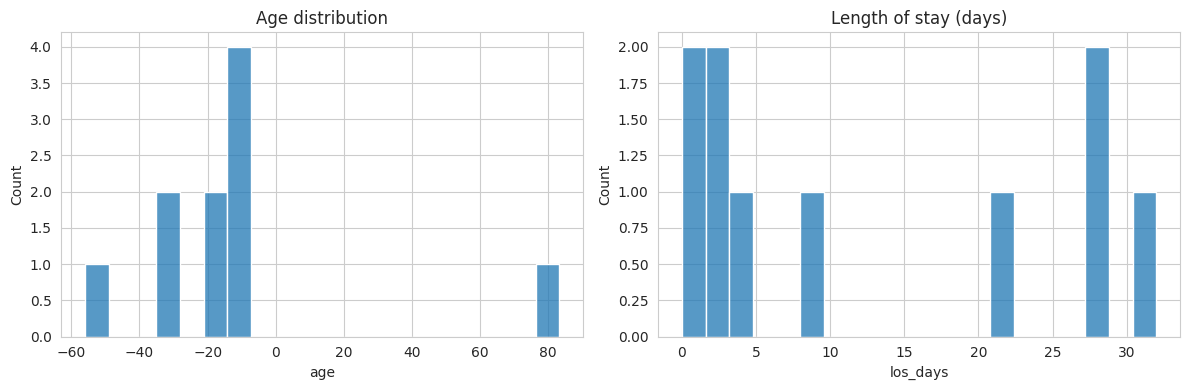

In [57]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(adm['age'].dropna(), kde=False, bins=20, ax=axes[0]).set_title('Age distribution')
sns.histplot(adm['los_days'].dropna(), bins=20, ax=axes[1]).set_title('Length of stay (days)')
plt.tight_layout()

In [58]:
adm_real = adm[(adm['age'] >= 0) & (adm['age'] <= 120)]

In [59]:
adm_real.shape

(1, 28)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


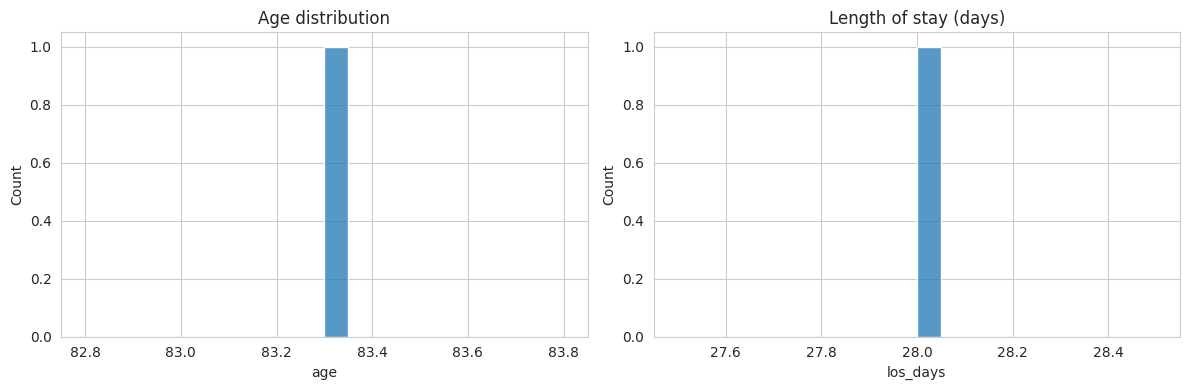

In [60]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(adm_real['age'].dropna(), kde=False, bins=20, ax=axes[0]).set_title('Age distribution')
sns.histplot(adm_real['los_days'].dropna(), bins=20, ax=axes[1]).set_title('Length of stay (days)')
plt.tight_layout()

### **Top diagnoses / admission types**

In [61]:
top_admit = adm['admission_type'].value_counts().head(10)
top_admit

admission_type
EMERGENCY    10
Name: count, dtype: int64

In [62]:
top_diag = adm['diagnosis'].dropna().value_counts().head(15)
top_diag

diagnosis
UPPER GI BLEED                     1
LUNG CANCER;SHORTNESS OF BREATH    1
STROKE/TIA                         1
ABDOMINAL PAIN                     1
CONGESTIVE HEART FAILURE           1
HYPOTENSION                        1
HEPATIC ENCEP                      1
SEIZURE;STATUS EPILEPTICUS         1
SHORTNESS OF BREATH                1
VOLVULUS                           1
Name: count, dtype: int64

### **Visualize time-series for a single patient/stay**

In [63]:
example_hadm = admissions_full.iloc[0]['hadm_id']
df_v = charts[charts['hadm_id']==example_hadm].dropna(subset=['valuenum'])

In [64]:
# aggregate by hour to smooth
df_v['charttime'] = pd.to_datetime(df_v['charttime'], errors='coerce')

df_v = (
    df_v.set_index('charttime')
        .resample('1h') 
        .mean(numeric_only=True)
        .reset_index()
)

Text(0, 0.5, 'Value')

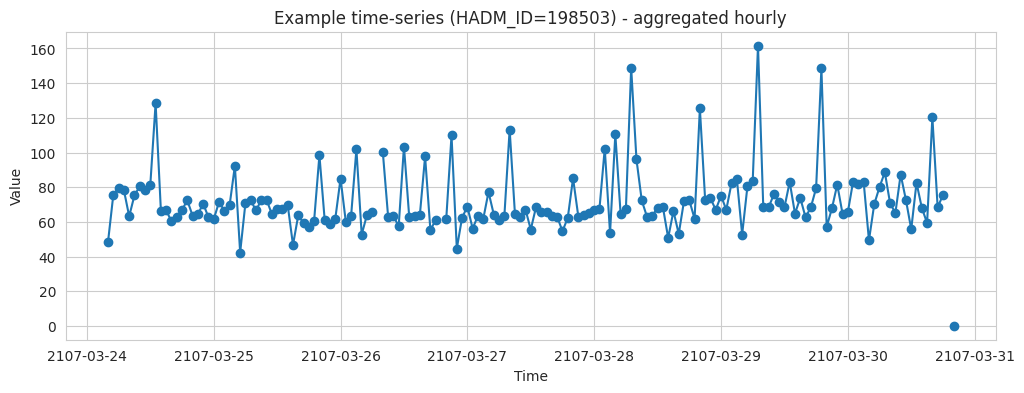

In [65]:
plt.figure(figsize=(12,4))
plt.plot(df_v['charttime'], df_v['valuenum'], marker='o', linestyle='-')
plt.title(f'Example time-series (HADM_ID={example_hadm}) - aggregated hourly')
plt.xlabel('Time'); plt.ylabel('Value')

### **Missingness heatmap & sparsity analysis**

In [66]:
def percent_non_null_by_hadm(df, group_col='hadm_id'):
    res = df.groupby(group_col)['valuenum'].apply(lambda x: x.notnull().mean()).reset_index().rename(columns={'valuenum':'frac_nonnull'})
    return res

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of fraction non-null (chart events per stay)')

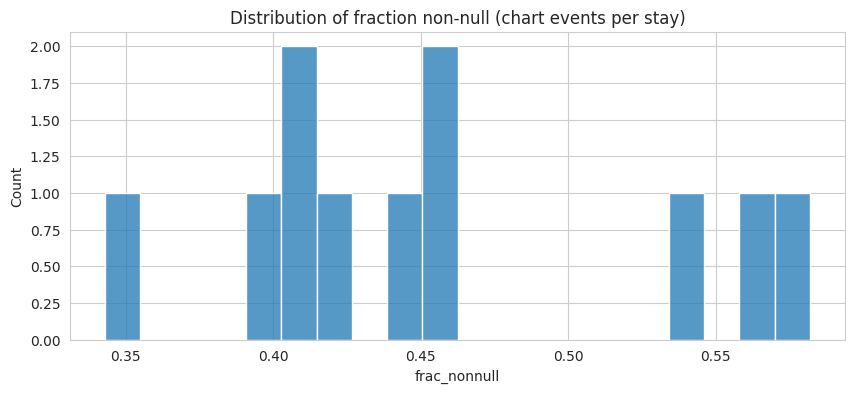

In [67]:
p_nonnull_labs = percent_non_null_by_hadm(labs)
p_nonnull_charts = percent_non_null_by_hadm(charts)
plt.figure(figsize=(10,4))
sns.histplot(p_nonnull_charts['frac_nonnull'], bins=20).set_title('Distribution of fraction non-null (chart events per stay)')


### **Simple cohort-level statistics & correlations**

Text(0.5, 1.0, 'Correlation matrix')

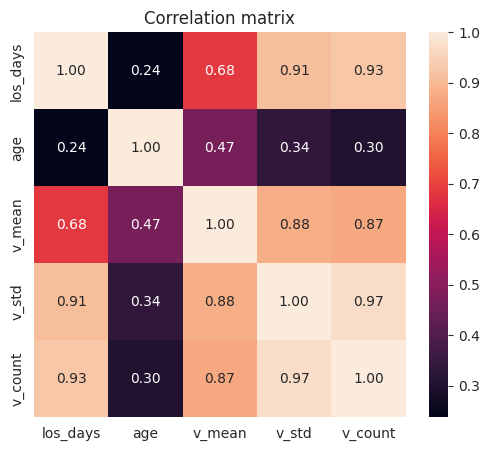

In [68]:
vitals_summary = charts.groupby('hadm_id')['valuenum'].agg(['mean','std','count']).reset_index().rename(columns={'mean':'v_mean','std':'v_std','count':'v_count'})
adm_stats = adm.merge(vitals_summary, on='hadm_id', how='left')
corr = adm_stats[['los_days','age','v_mean','v_std','v_count']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f'); plt.title('Correlation matrix')